In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-transformers

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla K80 GPUs


# Test

In [9]:
save_path = '/content/drive/MyDrive'
df_test = pd.read_csv(save_path + '/test.csv')

In [10]:
df_test.head(10)

,id,task,ans
0,0,Вопрос 1 Денис готовится провести соревнования...,0
1,1,Реши задачу.\nСколько коробок корма для собак ...,3
2,2,"Если групп элементов несколько, то применяется...",0
3,3,Вопрос1 ...,3
4,4,Для наглядной геометрической иллюстрации объём...,0
5,5,Реши задачу в тетради.\nДима осваивал новый ме...,0
6,6,Вопрос1\nВыполни следующие задания.\nВычисли с...,2
7,7,Перед тобой лежит карта возможных маршрутов дв...,0
8,8,На первом участке дороги машина ехала 2 ч со с...,0
9,9,Скорость гребцов по течению реки составляет 23...,0


In [11]:
df_test.shape

(514, 3)

# Wiki

In [12]:
import json
import pandas as pd

save_path = '/content/drive/MyDrive/'
with open(save_path + 'aiijc_comand_data.json', 'r') as f :
  data = json.load(f)
df = pd.DataFrame(data)

In [13]:
df.head()

,texts,links
животные,[Живо́тные (лат. Animalia) — традиционно (со в...,"[Волосатики, Национальная парламентская библио..."
музыка,"[Му́зыка (греч. μουσική, субстантивированное п...","[Мини-альбом, Волчья квинта, Ре (нота), Музыка..."
спорт,"[Спорт (англ. sport, сокращение от первоначаль...","[Олимпийская хартия, Болельщик, Ольмеки, Шаоли..."
литература,"[Литерату́ра (лат. lit(t)eratura, — написанное...","[Детская литература, Эфиопская литература, Сов..."


In [14]:
len(np.array(df.texts[0])[0])

15286

# NN

In [15]:
categories = ("животные", "музыка", "спорт", "литература")
categoriesTest = ("спорт", "музыка", "литература", "животные")
catToCatTest = [3, 1, 0, 2]

In [16]:
from nltk.corpus import stopwords
import nltk
import string

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
stopWordsRu = set(stopwords.words("russian"))
punctuation = set(string.punctuation + "—")
 
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя1234567890')
 
def validateWord(word):
  if word in stopWordsRu or word in punctuation:
    return False
  allSymValid = True
 
  for sym in word:
    if sym not in alphabet and sym not in punctuation:
      allSymValid = False
      break
 
  return allSymValid
 
def prepareText(text:str) -> list:
  out = ''
  for word in nltk.word_tokenize(text):
    word = word.strip()
    word = word.lower()
    if not validateWord(word):
      continue
    out += word + ' '
  return out
 
 
def generateTexts(texts, windowLen, need_prepare = True) -> list:
  out = []
  for text in tqdm(texts):
    byWords = text.split(' ')
    for window in range(len(byWords) // windowLen + 1):
      textPrepare = " ".join(byWords[window * windowLen: (window + 1) * windowLen])
      if need_prepare:
        prepared = prepareText(textPrepare)
      else:
        prepared = textPrepare
        
      if windowLen - len(prepared) > 0:
        prepared += " " * ( windowLen - len(prepared))
      out.append(prepared)
  return out

In [18]:
sentMaxLen = 50
MaxSymb = 200

In [19]:
sentences = []
labels = []

for i, cat in enumerate(categories):
  print(i)
  cat_texts = generateTexts(df.texts[cat], sentMaxLen)
  label = i
  for j in cat_texts:
    sentences.append(j[:MaxSymb])
    labels.append(label)

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
sentences = np.array(sentences)
labels = np.array(labels)

0


100%|██████████| 444/444 [00:13<00:00, 33.28it/s]


1


100%|██████████| 431/431 [00:13<00:00, 31.70it/s]


2


100%|██████████| 424/424 [00:15<00:00, 27.95it/s]


3


100%|██████████| 433/433 [00:17<00:00, 24.45it/s]


In [20]:
sentences.shape, labels.shape

((74687,), (74687,))

In [21]:
from sklearn.model_selection import train_test_split

X_train = sentences
Y_train = labels

In [22]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in X_train]

100%|██████████| 995526/995526 [00:01<00:00, 886548.66B/s]


In [23]:
len(tokenized_texts[0]), tokenized_texts[0]

(49,
 ['[CLS]',
  'лат',
  'т',
  '##радиционно',
  'време',
  '##н',
  'ар',
  '##ист',
  '##от',
  '##еля',
  'вы',
  '##деля',
  '##ема',
  '##я',
  'ка',
  '##те',
  '##гория',
  'органи',
  '##зм',
  '##ов',
  'настоящее',
  'время',
  'р',
  '##ас',
  '##с',
  '##мат',
  '##рива',
  '##ема',
  '##я',
  'качестве',
  'био',
  '##логического',
  'царства',
  'живот',
  '##ные',
  'являются',
  'основным',
  'объект',
  '##ом',
  'изучения',
  'з',
  '##оо',
  '##логии',
  'живот',
  '##ные',
  'от',
  '##нос',
  '##ят',
  '[SEP]'])

In [24]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
  input_ids,
  maxlen=200,
  dtype="long",
  truncating="post",
  padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [25]:
len(attention_masks)

74687

In [26]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, Y_train, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

In [27]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [28]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [29]:
train_labels

tensor([3, 1, 2,  ..., 3, 0, 0])

In [30]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
  train_data,
  sampler=RandomSampler(train_data),
  batch_size=16
)

In [31]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
  validation_data,
  sampler=SequentialSampler(validation_data),
  batch_size=16
)

In [32]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [33]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)
model.to(device)

100%|██████████| 714314041/714314041 [01:04<00:00, 11000379.91B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [34]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
  {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
  {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

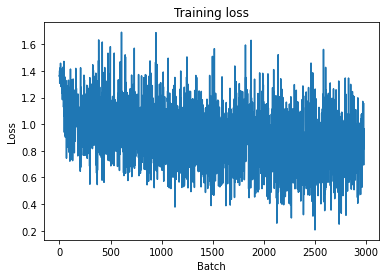

KeyboardInterrupt: ignored

In [35]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()

for step, batch in enumerate(train_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  optimizer.zero_grad()
  
  loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

  train_loss_set.append(loss[0].item())  
  
  loss[0].backward()
  
  optimizer.step()

  train_loss += loss[0].item()
  
  clear_output(True)
  plt.plot(train_loss_set)
  plt.title("Training loss")
  plt.xlabel("Batch")
  plt.ylabel("Loss")
  plt.show()

In [36]:
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = logits[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  batch_preds = np.argmax(logits, axis=1)
  batch_labels = label_ids
  valid_preds.extend(batch_preds)
  valid_labels.extend(batch_labels)

print("Accuracy на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))
print("f1: {0:.2f}%".format(
    f1_score(valid_labels, valid_preds, average='macro') * 100
))

Loss на обучающей выборке: 0.63815
Accuracy на валидационной выборке: 66.88%
f1: 66.90%


In [ ]:
valid_labels, valid_preds

# Test

In [38]:
def generateTextsTest(texts, windowLen, need_prepare = True) -> list:
  out = []
  byWords = texts.split(' ')
  for window in range(len(byWords) // windowLen + 1):
    textPrepare = " ".join(byWords[window * windowLen: (window + 1) * windowLen])
    if need_prepare :
      prepared = prepareText(textPrepare)
    else :
      prepared = textPrepare
      
    if windowLen - len(prepared) > 0:
      prepared += ' ' * ( windowLen - len(prepared))
    out.append(prepared)
  return out

In [39]:
"""
sentencesTest = []
labelsTest = []

for i in range(df_test.shape[0]):
  print(i)
  cat_texts = generateTextsTest(df_test.task[i], sentMaxLen)
  label = df_test.ans[i]
  for j in cat_texts:
    sentencesTest.append(j)
    labelsTest.append(label)
"""

sentencesTest = df_test.task
labelsTest = df_test.ans

sentencesTest = ["[CLS] " + sentence + " [SEP]" for sentence in sentencesTest]
sentencesTest = np.array(sentencesTest)
labelsTest = np.array(labelsTest)

In [40]:
tokenized_textsTest = [tokenizer.tokenize(sent) for sent in sentencesTest]

In [41]:
input_idsTest = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_textsTest]
input_idsTest = pad_sequences(
  input_idsTest,
  maxlen=200,
  dtype="long",
  truncating="post",
  padding="post"
)
attention_masksTest = [[float(i>0) for i in seq] for seq in input_idsTest]

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1150 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1655 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (737 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [42]:
test_inputs = torch.tensor(input_idsTest)
test_labels = torch.tensor(labelsTest)
test_masks = torch.tensor(attention_masksTest)

In [43]:
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(
  test_data,
  sampler=SequentialSampler(test_data),
  batch_size=16
)

In [44]:
test_preds, test_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = logits[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  batch_preds = np.argmax(logits, axis=1)
  batch_labels = label_ids
  test_preds.extend(batch_preds)
  test_labels.extend(batch_labels)

for i in range(len(test_preds)):
  test_preds[i] = catToCatTest[test_preds[i]]

print("Accuracy предсказаний на тестовой выборке: {0:.2f}%".format(
    accuracy_score(test_labels, test_preds) * 100
))
print("f1: {0:.2f}%".format(
    f1_score(test_labels, test_preds, average='macro') * 100
))

Accuracy предсказаний на тестовой выборке: 69.65%
f1: 63.88%


In [45]:
test_labels, test_preds

([0,
  3,
  0,
  3,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  2,
  3,
  0,
  2,
  0,
  0,
  2,
  0,
  2,
  2,
  0,
  0,
  3,
  0,
  3,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  3,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  2,
  3,
  3,
  2,
  3,
  2,
  0,
  0,
  0,
  2,
  1,
  1,
  2,
  3,
  0,
  0,
  3,
  3,
  0,
  0,
  2,
  0,
  2,
  2,
  2,
  0,
  0,
  3,
  2,
  2,
  3,
  3,
  3,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  2,
  1,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  3,
  0,
  2,
  3,
  3,
  0,
  0,
  2,
  2,
  0,
  3,
  0,
  0,
  0,
  2,
  2,
  2,
  0,
  0,
  0,
  3,
  0,
  2,
  0,
  0,
  2,
  0,
  0,
  2,
  3,
  0,
  2,
  2,
  0,
  2,
  0,
  3,
  2,
  0,
  0,
  3,
  2,
  2,
  2,
  2,
  3,
  0,
  2,
  0,
  0,
  3,
  3,
  2,
  0,
  2,
  0,
  3,
  0,
  0,
  2,
  3,
  1,
  3,
  0,
  0,
  3,
  0,
  2,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  2,
  2,
  0,
  3,
  3,
  0,
  2,
  0,
  0,
  2,
  3,
  1,
  3,
  0,
  0,
  0,
  2,
  3,
  0,
  0,
  3,
  0,
  0,
  3,
  0,
  3,


In [47]:
len(test_labels), len(test_preds)

(514, 514)